In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
engine.execute('SELECT max(date) FROM measurement').fetchall()

[('2017-08-23',)]

In [10]:
import datetime as dt


In [11]:
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores

precipt_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= '2016-08-24').\
    filter(measurement.date <= '2017-08-23').all()
precipt_data

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipt_df = pd.DataFrame(precipt_data).set_index('date')

#Rename the column from prcp to precipitation
precipt_df = precipt_df.rename(columns={'prcp': 'precipitation'})

# Sort the dataframe by date
precipt_df = precipt_df.sort_values(by="date").dropna()
precipt_df

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


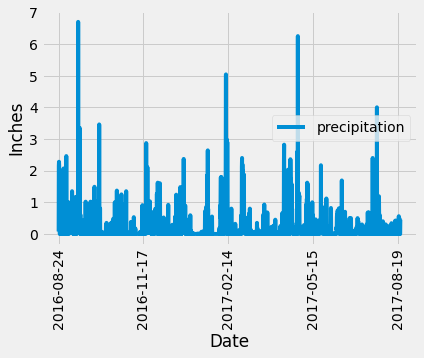

In [15]:
precipt_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.savefig('Precipitation Analysis.png')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipt_df.describe()


,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset

station_count = session.query(station.id).count()
print(f'There are {station_count} stations in the dataset.')

There are 9 stations in the dataset.


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

stations_active = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
stations_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

station_number = 'USC00519281'
session.query(func.min(measurement.tobs),
              func.max(measurement.tobs),
              func.avg(measurement.tobs)).filter(measurement.station == station_number).all()

[(54.0, 85.0, 71.66378066378067)]

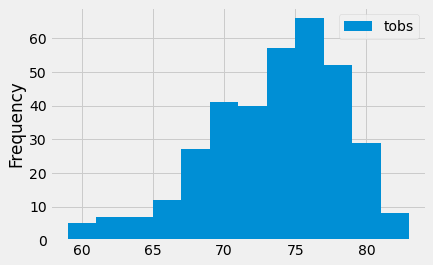

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_highest_obs = stations_active[0][0]

results = session.query(measurement.date, measurement.tobs).\
                        filter(measurement.date >= "2016-08-24").\
                        filter(measurement.date <= "2017-08-23").\
                        filter(measurement.station == station_highest_obs).all()

results_df = pd.DataFrame(results)
results_df.plot.hist(bins=12)
plt.savefig('Station Analysis.png')

# Close session

In [22]:
# Close Session
session.close()